In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)


n = 15
m = 45

kw = {
    'seed': 125396749,
    'speeds': [105],
    'chargers': list(range(1, 6)),
    'scale': (1e6, 1e6),
    'graph': {
        'directed': True,
    },
}


graph = src.rng.random_completely_connected_graph(
    n, m, **kw
)

In [3]:
graph.number_of_nodes(), graph.number_of_edges()

(60, 3600)

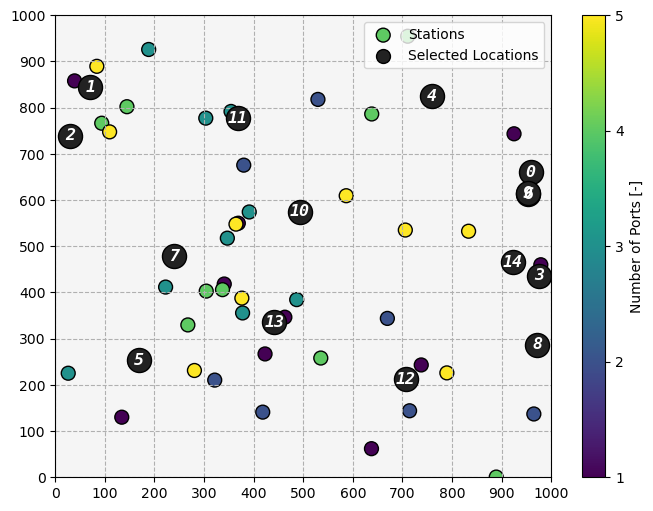

In [4]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [n for n in graph.nodes if 'destination' in n]
stations = [n for n in graph.nodes if 'station' in n]

destinations = src.graph.subgraph(graph, destinations)
stations = src.graph.subgraph(graph, stations)

kw = {
    'show_links': False,
    'node_field': 'n_dcfc',
    'scatter': {
        's': 100,
        'ec': 'k',
        # 'lw': 2,
        # 'marker': (4, 1, 0),
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Number of Ports [-]',
        'ticks': list(range(1, 6)),
    },
}

src.figures.plot_graph(
   stations, ax = ax, **kw,
)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#222222',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

src.figures.plot_graph(destinations, ax = ax, **kw)

x = [n['x'] for n in destinations._node.values()]
y = [n['y'] for n in destinations._node.values()]
n = [f'{n}' for n in range(destinations.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontweight': 'bold',
    'fontfamily': 'monospace',
    'color': '#ffffff'
}

for idx in range(len(n)):
    
    ax.text(x[idx], y[idx], n[idx], **kw)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend(loc = 1)

for h in legend.legendHandles:
    h._sizes = [100]

ax.grid(ls = '--')

fig.savefig(
    'Paper/figs/random_example_number_chargers.png',
    bbox_inches = 'tight',
    dpi = 300,
)

In [8]:
'''
Distributions of SOC at start and end of charge event
'''
from scipy.stats import gamma, beta, rv_histogram

n = 1000
m = 1000

dist_initial = beta(4, 11)
dist_final = beta(17, 4)

x_initial = np.linspace(dist_initial.ppf(.001), dist_initial.ppf(.999), n)
x_final = np.linspace(dist_final.ppf(.001), dist_final.ppf(.999), n)

x = np.linspace(0, 1, n)



delta_soc = dist_final.rvs(m) - dist_initial.rvs(m)

args_delta = beta.fit(delta_soc)

dist_delta = beta(*args_delta)

args_delta

(93.56849388241605, 14.647440568808115, -3.1420684876537965, 4.265587656967583)

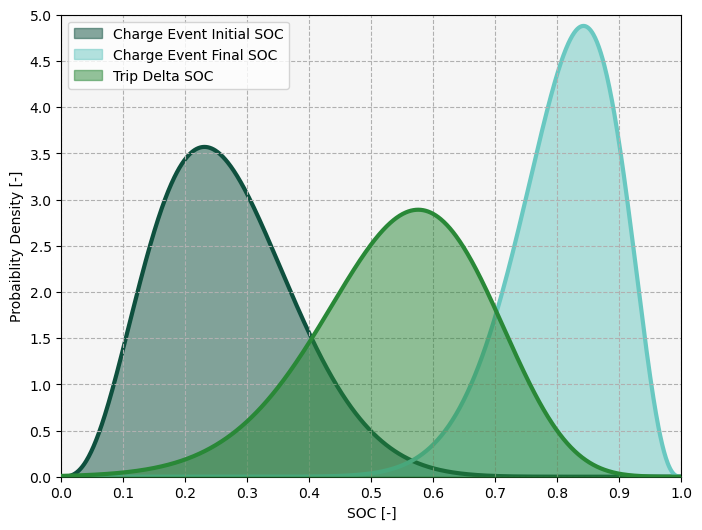

In [9]:
fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'color': '#0e503e',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, dist_initial.pdf(x), **kw)

kw = {
    'color': '#0e503e',
    'zorder': 0,
    'alpha': .5,
    'label': 'Charge Event Initial SOC'
}

ax.fill_between(x, 0, dist_initial.pdf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 1,
    'lw': 3,
}

ax.plot(x, dist_final.pdf(x), **kw)

kw = {
    'color': '#69c8c1',
    'zorder': 0,
    'alpha': .5,
    'label': 'Charge Event Final SOC'
}

ax.fill_between(x, 0, dist_final.pdf(x), **kw)

kw = {
    'color': '#298837',
    'zorder': 5,
    'lw': 3,
}

ax.plot(x, dist_delta.pdf(x), **kw)

kw = {
    'color': '#298837',
    'zorder': 4,
    'alpha': .5,
    'label': 'Trip Delta SOC'
}

ax.fill_between(x, 0, dist_delta.pdf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 5],
    'xticks': np.linspace(0, 1, 11),
    'yticks': np.linspace(0, 5, 11),
    'xlabel': 'SOC [-]',
    'ylabel': 'Probaiblity Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

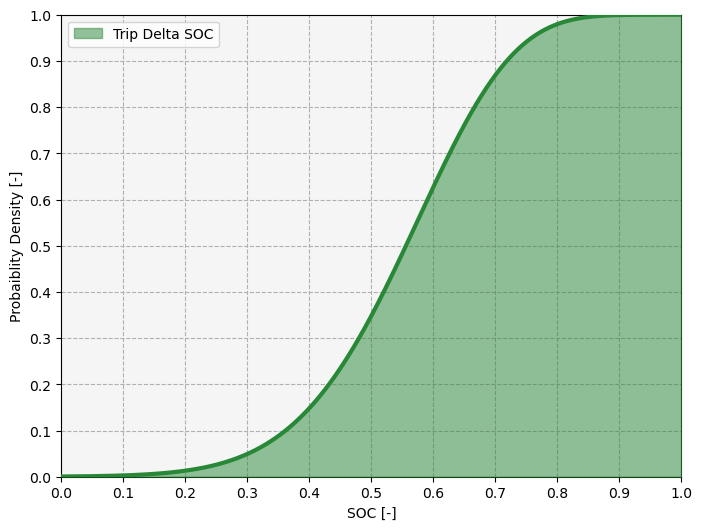

In [10]:
fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'color': '#298837',
    'zorder': 5,
    'lw': 3,
}

ax.plot(x, dist_delta.cdf(x), **kw)

kw = {
    'color': '#298837',
    'zorder': 4,
    'alpha': .5,
    'label': 'Trip Delta SOC'
}

ax.fill_between(x, 0, dist_delta.cdf(x), **kw)

kw = {
    'xlim': [x[0], x[-1]],
    'ylim': [0, 1],
    'xticks': np.linspace(0, 1, 11),
    'yticks': np.linspace(0, 1, 11),
    'xlabel': 'SOC [-]',
    'ylabel': 'Probaiblity Density [-]',
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

In [21]:
def add_edge_soc(graph, range, field = 'distance'):

    for source, adj in graph._adj.items():
        for target, edge in adj.items():

            edge['soc'] = edge[field] / range

    return graph

def add_edge_charge_time(graph, charge_rate, delay = 300):

    for source, adj in graph._adj.items():
        for target, edge in adj.items():

            edge['total_time'] = edge['time'] + edge['soc'] / charge_rate + delay

    return graph

def add_edge_probability_density(graph, distribution, field = 'soc'):

    to_destination_weight = dist_delta.pdf(dist_delta.ppf(.5))

    for source, adj in graph._adj.items():
        for target, edge in adj.items():

            if edge['soc'] > 1:

                edge['probability_density'] = 0

            elif graph._node[target]['type'] == 'destination':

                edge['probability_density'] = to_destination_weight

            else:

                edge['probability_density'] = distribution.pdf(edge[field])

            edge['inverse_probability_density'] = (
                to_destination_weight - edge['probability_density']
            )

    return graph

def minimum_probability_subgraph(graph, p = 0):

    subgraph = src.graph.subgraph(
        graph, [k for k in graph.nodes]
    )

    _adj = {}

    for source, adj in graph._adj.items():

        _adj[source] = {}
        
        for target, edge in adj.items():

            if (edge['probability_density'] >= p) and (source != target):

                _adj[source][target] = edge

    subgraph._adj = _adj
    
    return subgraph

In [22]:
vehicle_range = 300e3
charge_rate = 1 / (45 * 60)

graph = add_edge_soc(graph, vehicle_range)

graph = add_edge_charge_time(graph, charge_rate)

graph = add_edge_probability_density(graph, dist_delta)

subgraph = minimum_probability_subgraph(graph, .05)

In [23]:
subgraph.is_directed(), subgraph.number_of_edges()

(True, 2184)

In [28]:
# nx.information_centrality(graph)

destinations = [k for k, v in subgraph._node.items() if v['type'] == 'destination']

centralities = {
    # 'degree': nx.degree_centrality(graph, weight = 'probability_density'),
    'eigenvector_time': nx.eigenvector_centrality(
        subgraph, weight = 'time'
    ),
    'eigenvector_prb': nx.eigenvector_centrality(
        subgraph, weight = 'probability_density'
    ),
    'betweenness_time': nx.betweenness_centrality_subset(
        subgraph,
        sources = destinations,
        targets = destinations,
        weight = 'total_time'
    ),
    'betweenness_ipdf': nx.betweenness_centrality_subset(
        subgraph,
        sources = destinations,
        targets = destinations,
        weight = 'inverse_probability_density'
    ),
    'laplacian_time': nx.laplacian_centrality(
        subgraph,
        weight = 'total_time'
    ),
    'laplacian_prb': nx.laplacian_centrality(
        subgraph,
        weight = 'probability_density'
    ),
    'percolation_time': nx.percolation_centrality(
        subgraph,
        weight = 'total_time'
    ),
    'percolation_prb': nx.percolation_centrality(
        subgraph,
        weight = 'probability_density'
    ),
}

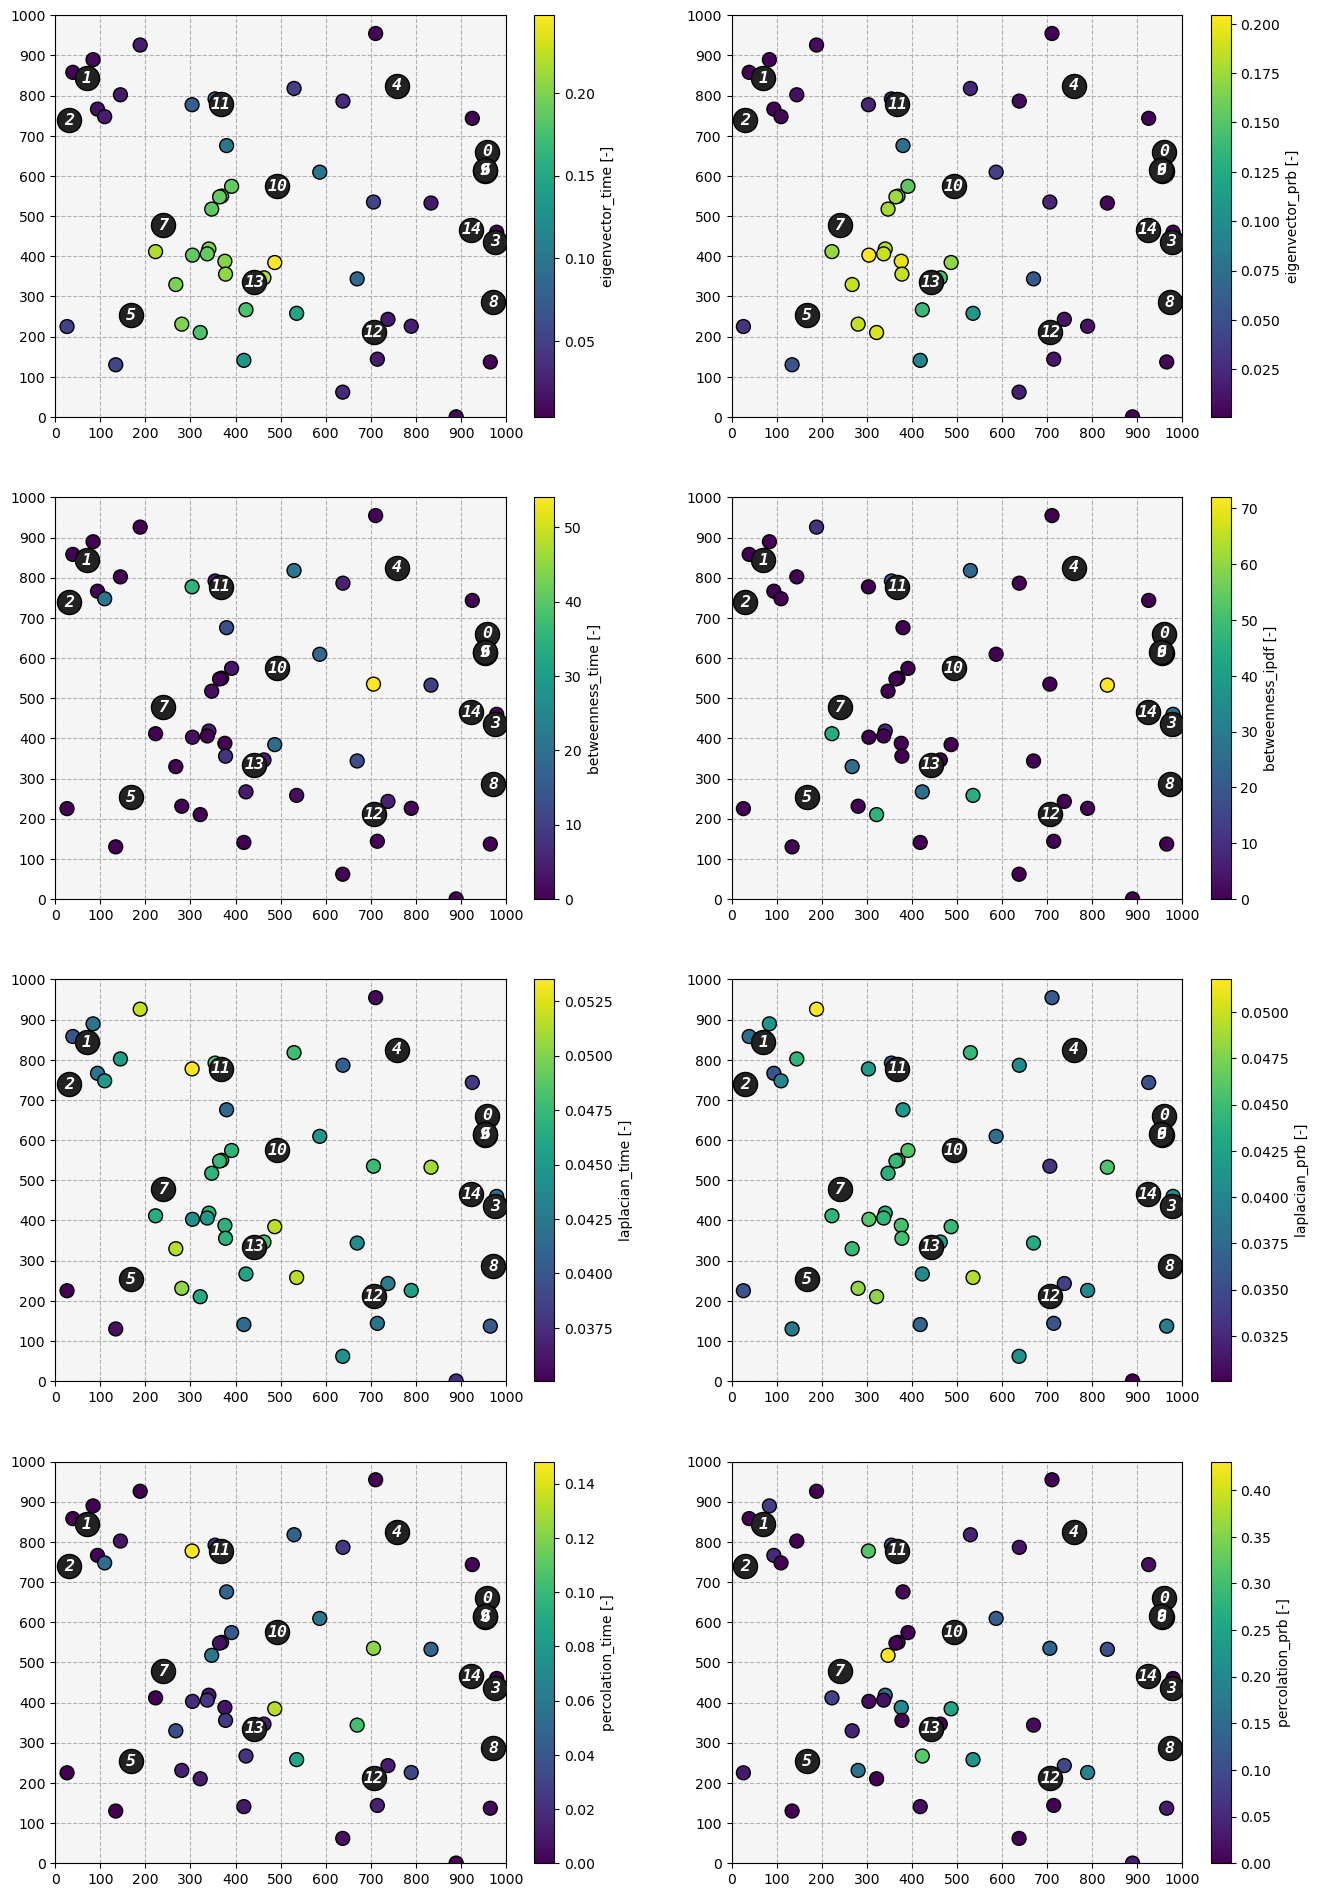

In [29]:
deep_reload(src)

columns = 2

# rows = len(centralities) // columns

rows = int(np.ceil(len(centralities) / columns))

fig, ax = plt.subplots(rows, columns, figsize = (8 * columns, 6 * rows))

destinations = [n for n in subgraph.nodes if 'destination' in n]
stations = [n for n in subgraph.nodes if 'station' in n]

destinations = src.graph.subgraph(subgraph, destinations)
stations = src.graph.subgraph(subgraph, stations)

r = 0
c = 0

for key, val in centralities.items():
    # print(val)
    

    # print(r, c)

    for source, node in stations._node.items():
        # print(source, val.get(source, np.nan))

        node['plot_value'] = val.get(source, np.nan)
    # break

    kw = {
        'show_links': False,
        'node_field': 'plot_value',
        'scatter': {
            's': 100,
            'ec': 'k',
            'zorder': 3,
            'label': 'Stations',
        },
        'colorbar': {
            'label': f'{key} [-]',
            # 'ticks': list(range(1, 6)),
        },
    }
    
    src.figures.plot_graph(
       stations, ax = ax[r, c], **kw,
    )

    kw = {
        'show_links': False,
        'scatter': {
            's': 300,
            'ec': 'k',
            'fc': '#222222',
            'zorder': 4,
            'label': 'Selected Locations',
        },
    }
    
    src.figures.plot_graph(destinations, ax = ax[r, c], **kw)
    
    x = [n['x'] for n in destinations._node.values()]
    y = [n['y'] for n in destinations._node.values()]
    n = [f'{n}' for n in range(destinations.number_of_nodes())]
    
    kw = {
        'zorder': 5,
        'horizontalalignment': 'center',
        'verticalalignment': 'center',
        'fontstyle': 'italic',
        'fontsize': 'large',
        'fontweight': 'bold',
        'fontfamily': 'monospace',
        'color': '#ffffff'
    }
    
    for idx in range(len(n)):
        
        ax[r, c].text(x[idx], y[idx], n[idx], **kw)

    kw = {
        'xticks': np.linspace(-5e5, 5e5, 11),
        'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
        'xlim': (-5e5, 5e5),
        'yticks': np.linspace(-5e5, 5e5, 11),
        'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
        'ylim': (-5e5, 5e5),
        'facecolor': 'whitesmoke',
    }

    _ = ax[r, c].set(**kw)

    kw = {
        'ls': '--',
        'zorder': 0,
    }
    
    ax[r, c].grid(**kw)

    if c == 0:

        c = 1
    
    elif c == 1:

        c = 0
        r += 1

# fig.savefig(
#     'Paper/figs/random_example_number_chargers.png',
#     bbox_inches = 'tight',
#     dpi = 300,
# )